In [1]:
import numpy as np
import matplotlib as mpl
import matplotlib.pyplot as plt

import pandas as pd
import os

from tqdm import tqdm
from cycler import cycler

from astropy.io import fits

import corsikaio

In [2]:
m_mu = 0.106 #GeV/c^2

In [3]:
def get_stats(lgE, m=m_mu, plot=True):
    part = corsikaio.CorsikaParticleFile('proton/lgE_{:.1f}/000000/DAT000000'.format(lgE))
    A = np.concatenate([run.particles for run in part])
    
    bound = np.logical_or(A['particle_description']//1000==5, A['particle_description']//1000==6)
    
    mu = A[bound]
    
    p = np.sqrt(mu['px']**2 + mu['py']**2 + mu['pz']**2)
    E = np.sqrt(p**2 + m**2)
    cosTH = mu['pz']/p
    
    if plot:
        fig, ax = plt.subplots(1,1, figsize=(6,5), tight_layout=True)
        ax.scatter(E, cosTH, s=0.1)
        ax.set(xscale = 'log',
               xlabel='Energy [GeV]',
               ylabel='cos theta')
        plt.title('Muon Zenith Angle by Energy')
        
        Esp = np.logspace(-1,4,50)

        fig, ax = plt.subplots(1,1, figsize=(6,5), tight_layout=True)
        ax.hist(E, bins=Esp)
        ax.set(xscale = 'log',
               xlabel='Energy [GeV]',
               #yscale='log',
               ylabel='count')
        plt.title('Muon Energy Spectrum')
        
        X, xedge, yedge = np.histogram2d(np.log10(E), cosTH, bins=30)
        fig, ax = plt.subplots(1,1, figsize=(6,5), tight_layout=True)
        ax.imshow(X.T, extent=[xedge[0], xedge[-1], yedge[0], yedge[-1]], origin='lower', aspect='auto')
        ax.set(xlabel='log Energy [GeV]',
               #yscale='log',
               ylabel='cos theta')
        plt.title('Muon Energy Spectrum')
        
    cut = cosTH>0 #I ran into a particle that had NEGATIVE cosTH??  It was traveling UP??  Messed up the whole calculation
        
    return E[cut], cosTH[cut]

In [4]:
def E_deep(E0, cosTH, h):
    a = 0.227 #energy loss due to ionization (GeV cm^2/hg)
    b = 2.44e-4 #sum of fractional radiation losses (cm^2/hg)
    
    # axis0: particle
    # axis1: depth
    
    E0 = np.reshape(E0, (-1, 1))
    cosTH = np.reshape(cosTH, (-1, 1))
    h = np.reshape(h, (1,-1))
    
    E = (E0 + a/b)*np.exp(-h*b/cosTH)-a/b
    
    return E.clip(min=0)

In [5]:
def toFITS(lgE):
    E0, cosTH = get_stats(lgE, plot=False)
    
    EnergyHDU = fits.PrimaryHDU(data=E0)
    EnergyHDU.header['EXTNAME'] = 'ENERGY'
    EnergyHDU.header['BUNIT'] = 'GeV'

    cosHDU = fits.ImageHDU(data=cosTH)
    cosHDU.header['EXTNAME'] = 'COSTH'
    
    hdul = fits.HDUList([EnergyHDU, cosHDU])

    outfile = 'proton_fits/lgE_{:.1f}.fits'.format(lgE)
    hdul.writeto(outfile)
    
    return

In [6]:
def data(lgE, h, alpha=0.75):
    hdus = fits.open('proton_fits/lgE_{:.1f}.fits'.format(lgE))
    
    E0 = hdus['ENERGY'].data
    cosTH = hdus['COSTH'].data
    
    E = E_deep(E0, cosTH, h)
    
    N = np.sum(E>0, axis=0)
    E_avg = np.sum(E**alpha *(E>0), axis=0)/N.clip(min=1)
    
    return [E_avg, N]

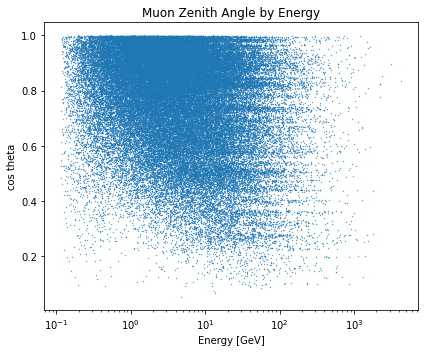

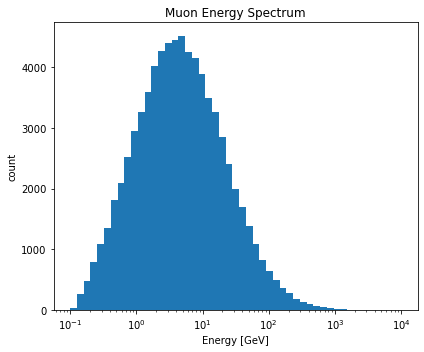

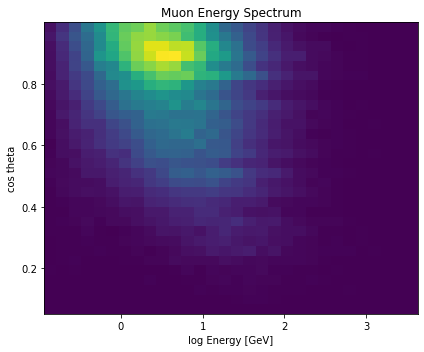

In [7]:
E0, cosTH = get_stats(13.0)

In [8]:
E0, cosTH

(array([ 32.876488  ,  13.835937  ,  39.770626  , ...,   1.2291083 ,
          0.46758634, 394.10193   ], dtype=float32),
 array([0.11873692, 0.12408027, 0.08580472, ..., 0.7613353 , 0.84132475,
        0.7283028 ], dtype=float32))

In [9]:
dh = 10
h = np.arange(0, 1000+dh, dh)

lgE_p = np.arange(11, 14.1, 0.1)

In [10]:
for lgE in tqdm(lgE_p):
    toFITS(lgE)

100%|██████████████████████████████████████████████████████████████████████████████████| 31/31 [01:30<00:00,  2.91s/it]


In [11]:
X = np.array([data(lgE, h, alpha=1) for lgE in tqdm(lgE_p)])

100%|██████████████████████████████████████████████████████████████████████████████████| 31/31 [00:07<00:00,  3.92it/s]


In [12]:
E_avg = X[:,0]
N = X[:,1]

In [13]:
E_avg[:,-1]

array([  0.        ,   0.        ,   0.        ,   0.        ,
         0.        ,   0.        ,   0.        ,   0.        ,
        28.76168658,  24.70539583,  44.5646873 ,  95.21322965,
        75.99209332,  77.03729804, 119.74630897, 136.38690897,
       116.01509713, 230.28807635, 199.00019053, 188.29007031,
       234.07085791, 216.25163939, 235.84500534, 263.84803856,
       290.19368155, 304.81335771, 338.87153017, 324.51852057,
       326.33731484, 334.11270592, 393.57010551])

In [14]:
N[:,0]

array([  1308.,   1668.,   2067.,   2472.,   3236.,   3853.,   4719.,
         5553.,   6871.,   7955.,   9969.,  11782.,  15252.,  17999.,
        21715.,  26253.,  32612.,  40320.,  50127.,  62554.,  75613.,
        96999., 116584., 147336., 179686., 240335., 273116., 345091.,
       424671., 524615., 652393.])

Text(0.5, 1.0, 'Average Muon Energy by Depth')

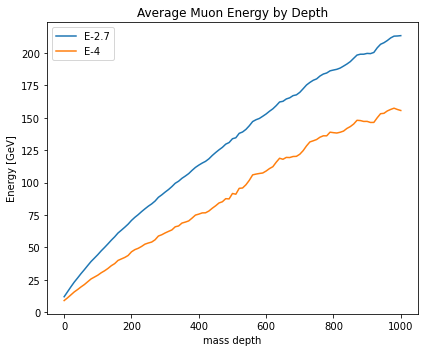

In [15]:
N_E = np.exp(-2.7*lgE_p)
N_E = np.reshape(N_E, (-1, 1))

E_avg0 = np.average(E_avg, weights=N*N_E, axis=0)

N_E = np.exp(-4*lgE_p)
N_E = np.reshape(N_E, (-1, 1))

E_avg1 = np.average(E_avg, weights=N*N_E, axis=0)

fig, ax = plt.subplots(1,1, figsize=(6,5), tight_layout=True)
ax.plot(h, E_avg0, label='E-2.7')
ax.plot(h, E_avg1, label='E-4')
ax.set(xlabel='mass depth',
        ylabel='Energy [GeV]')
ax.legend()
plt.title('Average Muon Energy by Depth')

In [16]:
N_E = np.exp(-4*lgE_p)
N_E = np.reshape(N_E, (-1, 1))

np.average(E_avg, weights=N*N_E, axis=0)

array([  9.06034767,  11.1476877 ,  13.4157625 ,  15.71161177,
        17.55436568,  19.56300293,  21.37794965,  23.56270424,
        25.74170434,  27.17522759,  28.62492323,  30.4726276 ,
        31.99057172,  33.7867588 ,  35.9132132 ,  37.51372142,
        39.99613147,  41.15089522,  42.28475321,  43.7948885 ,
        46.63235786,  48.308361  ,  49.33679138,  50.78404285,
        52.53250308,  53.42514033,  54.15640337,  55.88155578,
        58.79683871,  59.79372625,  61.18344545,  62.3796467 ,
        63.50920713,  65.93758604,  66.57448386,  68.80294351,
        69.54682385,  70.46103158,  72.61847637,  74.95095317,
        75.69275396,  76.62596525,  76.71018345,  78.08769476,
        80.22775604,  82.11239318,  84.28937511,  85.22743338,
        87.60196258,  87.42560669,  91.59829472,  91.04705063,
        95.57127783,  95.83803329,  98.31187511, 101.75019867,
       105.95714001, 106.56295637, 107.02921608, 107.40532284,
       108.91849847, 110.8072509 , 112.25622358, 115.72

In [17]:
E_weight = E_avg*N/np.sum(N, axis=0)

np.sum(E_weight*N_E, axis=0)

array([1.56030390e-21, 2.04367340e-21, 2.33135619e-21, 2.51213821e-21,
       2.63463317e-21, 2.71889455e-21, 2.77717085e-21, 2.82493913e-21,
       2.86538883e-21, 2.88998345e-21, 2.90605598e-21, 2.91442093e-21,
       2.91745208e-21, 2.91792351e-21, 2.91818325e-21, 2.91904231e-21,
       2.91430434e-21, 2.91351828e-21, 2.90596345e-21, 2.89603959e-21,
       2.89078126e-21, 2.88121735e-21, 2.87265702e-21, 2.86133954e-21,
       2.85157729e-21, 2.84346640e-21, 2.82916468e-21, 2.81833969e-21,
       2.80665981e-21, 2.79177968e-21, 2.77942160e-21, 2.76694508e-21,
       2.75433258e-21, 2.74592497e-21, 2.73419113e-21, 2.71725970e-21,
       2.70208619e-21, 2.68861683e-21, 2.67687165e-21, 2.66687818e-21,
       2.65709226e-21, 2.63912832e-21, 2.62273721e-21, 2.60693204e-21,
       2.59224867e-21, 2.57942596e-21, 2.56574055e-21, 2.55561185e-21,
       2.54287530e-21, 2.53450540e-21, 2.53029352e-21, 2.51712100e-21,
       2.50944023e-21, 2.49876087e-21, 2.49163101e-21, 2.48821643e-21,
      

In [18]:
E_avg[-4]

array([ 15.51081554,  23.83999109,  31.21031595,  37.92333648,
        44.26604081,  50.1571416 ,  55.79608471,  61.31914027,
        66.86604667,  72.09885653,  77.37792009,  82.34819832,
        87.03272457,  91.778283  ,  96.49947208, 100.74058065,
       105.23835844, 109.73229993, 113.68033235, 118.45165263,
       122.94716898, 126.65008115, 130.77491965, 134.33493324,
       138.48759044, 142.18469384, 146.24216746, 150.66010939,
       154.25769776, 158.60854295, 162.12249127, 165.69358292,
       169.42118253, 172.29139096, 176.19672594, 179.34479455,
       182.10600844, 185.38307783, 188.1910516 , 192.06674103,
       195.88096809, 198.60714737, 201.99688486, 204.10562879,
       206.68364687, 209.15497059, 212.24997995, 215.24299094,
       217.67313221, 220.44942821, 224.13457754, 227.32700336,
       230.29048665, 233.20616849, 237.6291977 , 239.18222643,
       242.21852425, 244.30573285, 245.50829755, 248.47975613,
       250.6618843 , 254.21024328, 256.17648054, 258.57